In [1]:
# Celda 1: Importar Librerías y Módulos (con adiciones para paralelismo)

import os
import numpy as np
import rasterio
from datetime import datetime
from tqdm import tqdm
import time

# --- ADICIONES PARA PARALELIZACIÓN Y MONITOREO ---
import threading
import psutil
from joblib import Parallel, delayed
# ---------------------------------------------------

# Importar los módulos personalizados del paquete lcp
import lcp.data_loader as dl
import lcp.processing as proc
import lcp.pathfinder as pf
import lcp.utils as utils

print("Módulos cargados exitosamente.")

Módulos cargados exitosamente.


In [2]:
# Celda 2: Definición de Funciones (Worker y Monitor)

def lcp_worker(args):
    """
    Función que ejecuta el cálculo jerárquico completo para UN par de puntos.
    --- VERSIÓN CON LOGGING DETALLADO Y FLUSH=TRUE ---
    """
    origin_id, origin_coords, dest_id, dest_coords, shared_data = args
    
    # --- [CORRECCIÓN] Añadido flush=True a todos los print ---
    print(f"--- Calculando ruta: {origin_id} -> {dest_id} ---", flush=True)
    
    cost_data_high_res = shared_data['cost_data_high_res']
    main_search_mask = shared_data['main_search_mask']
    src_transform = shared_data['src_transform']
    src_crs = shared_data['src_crs']
    src_nodata = shared_data['src_nodata']
    src_res = shared_data['src_res']
    DOWNSAMPLING_FACTORS = shared_data['DOWNSAMPLING_FACTORS']
    CORRIDOR_BUFFER_PIXELS = shared_data['CORRIDOR_BUFFER_PIXELS']
    HEURISTIC_WEIGHT = shared_data['HEURISTIC_WEIGHT']
    OUTPUT_DIR = shared_data['OUTPUT_DIR']

    try:
        start_pixel_hr = proc.world_to_pixel(src_transform, origin_coords[0], origin_coords[1])
        end_pixel_hr = proc.world_to_pixel(src_transform, dest_coords[0], dest_coords[1])

        path_found_lr, path_pixels_lr, successful_factor, trans_low = False, None, None, None
        print(f"[{origin_id} -> {dest_id}] -> FASE 1: Buscando en baja resolución...", flush=True)
        for factor in DOWNSAMPLING_FACTORS:
            print(f"  [{origin_id} -> {dest_id}] Intentando con factor de remuestreo {factor}x...", flush=True)
            
            cost_lr = cost_data_high_res[::factor, ::factor]
            trans_lr = src_transform * src_transform.scale(factor, factor)
            dx_lr, dy_lr = src_res[0] * factor, src_res[1] * factor
            mask_lr = main_search_mask[::factor, ::factor]
            start_lr = (start_pixel_hr[0] // factor, start_pixel_hr[1] // factor)
            end_lr = (end_pixel_hr[0] // factor, end_pixel_hr[1] // factor)
            
            found, came_from_lr = pf.a_star_search(cost_lr, src_nodata, start_lr, end_lr, dx_lr, abs(dy_lr), HEURISTIC_WEIGHT, mask_lr)
            if found:
                print(f"  [{origin_id} -> {dest_id}] Éxito con factor {factor}.", flush=True)
                path_found_lr, successful_factor, trans_low = True, factor, trans_lr
                path_pixels_lr = pf.reconstruct_path(came_from_lr, start_lr, end_lr)
                break
            else:
                print(f"  [{origin_id} -> {dest_id}] Falló con factor {factor}.", flush=True)
        
        print(f"[{origin_id} -> {dest_id}] -> FASE 2: Buscando en alta resolución...", flush=True)
        path_found_hr, came_from_hr = False, None
        if path_found_lr and path_pixels_lr is not None:
            print(f"  [{origin_id} -> {dest_id}] Creando corredor...", flush=True)
            corridor_mask = proc.create_search_corridor(path_pixels_lr, cost_data_high_res.shape, successful_factor, CORRIDOR_BUFFER_PIXELS)
            final_search_mask = np.logical_and(corridor_mask, main_search_mask)
            path_found_hr, came_from_hr = pf.a_star_search(cost_data_high_res, src_nodata, start_pixel_hr, end_pixel_hr, src_res[0], abs(src_res[1]), HEURISTIC_WEIGHT, final_search_mask)
        if not path_found_hr:
            print(f"  [{origin_id} -> {dest_id}] Búsqueda en corredor fallida o no realizada. Iniciando PLAN B...", flush=True)
            path_found_hr, came_from_hr = pf.a_star_search(cost_data_high_res, src_nodata, start_pixel_hr, end_pixel_hr, src_res[0], abs(src_res[1]), HEURISTIC_WEIGHT, main_search_mask)

        if path_found_hr:
            path_pixels_hr = pf.reconstruct_path(came_from_hr, start_pixel_hr, end_pixel_hr)
            if path_pixels_lr is not None:
                p1_path = os.path.join(OUTPUT_DIR, f"ruta_fase1_{origin_id}_a_{dest_id}.shp")
                utils.save_path_to_shapefile(path_pixels_lr, trans_low, src_crs, p1_path)
            final_path_shp = os.path.join(OUTPUT_DIR, f"ruta_final_{origin_id}_a_{dest_id}.shp")
            utils.save_path_to_shapefile(path_pixels_hr, src_transform, src_crs, final_path_shp)
            
            print(f"  [{origin_id} -> {dest_id}] ÉXITO FINAL. Ruta guardada en: {os.path.basename(final_path_shp)}", flush=True)
            return ("Éxito", origin_id, dest_id)
        else:
            print(f"  [{origin_id} -> {dest_id}] ERROR CRÍTICO: No se pudo encontrar ninguna ruta.", flush=True)
            return ("Fallo", origin_id, dest_id)

    except Exception as e:
        print(f"  [{origin_id} -> {dest_id}] ERROR INESPERADO: {e}", flush=True)
        return ("Error", origin_id, dest_id, str(e))

# La función de monitoreo no cambia
def resource_monitor(stop_event, records_list, interval=1):
    process = psutil.Process(os.getpid())
    while not stop_event.is_set():
        cpu = psutil.cpu_percent(interval=None)
        mem = sum(p.memory_info().rss for p in [process] + process.children(recursive=True)) / (1024 * 1024)
        records_list.append({'cpu': cpu, 'mem_mb': mem})
        time.sleep(interval)
    
print("Funciones 'worker' (con logging forzado) y 'monitor' para la ejecución paralela definidas.")

Funciones 'worker' (con logging forzado) y 'monitor' para la ejecución paralela definidas.


In [ ]:
# --- 1. PARÁMETROS CONFIGURABLES POR EL USUARIO ---
BASE_DIR = os.getcwd()

# --- 1.1 Preguntar a usuario nombre de carpeta con archivos
"""
Determinar carpeta con pop-up nativo del SO
Problema -> La ventana de eleccion de carpeta aparece por debajo de la ventana actual
data_path = askdirectory(title='Seleccionar carpeta con archivos a usar', initialdir = BASE_DIR) 
DATA_DIR = os.path.abspath(data_path)
"""
# Pregunta por nombre de carpeta en la línea misma
carpeta_user = input("Cuál es el nombre de la carpeta con tus datos? (Tiene que estar dentro de /output): ")
DATA_DIR = os.path.join(BASE_DIR, 'data', carpeta_user)
print(f"Recuerda que tus archivos deben llamarse 'cost.tif', 'points.shp' y 'area-mask.shp'\nLa carpeta a usar será {carpeta_user}")

# --- 1.2 Usar output por defecto
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = os.path.join(BASE_DIR, 'output', f'session_{timestamp}_AllToAll')
SESSION_DIR = os.path.join(BASE_DIR, 'output')
COST_RASTER_PATH = os.path.join(DATA_DIR, 'cost.tif')
ALL_POINTS_SHAPEFILE = os.path.join(DATA_DIR, 'points.shp')
MASK_SHAPEFILE_PATH = os.path.join(DATA_DIR, 'area-mask.shp')
ID_FIELD_NAME = input("Cuál es el nombre de la columna de id en tu archivo?")
DOWNSAMPLING_FACTORS = [32, 20, 10]
CORRIDOR_BUFFER_PIXELS = 150
HEURISTIC_WEIGHT = 1.0
N_JOBS = -2

# --- 2. EJECUCIÓN DEL ANÁLISIS ---
opcionRutas = input("Juntar y exportar las rutas a un solo archivo posterior al análisis? (Y/N)")
os.makedirs(OUTPUT_DIR, exist_ok=True)
monitoring_records = []
print(f"Configuración lista. Los resultados se guardarán en: {OUTPUT_DIR}")

try:
    all_points, points_crs = dl.load_points_as_dict(ALL_POINTS_SHAPEFILE, ID_FIELD_NAME)
    
    with dl.load_raster(COST_RASTER_PATH) as src:
        print("Cargando superficie de costo y máscara a memoria...")
        cost_data_high_res = src.read(1)
        
        if MASK_SHAPEFILE_PATH and os.path.exists(MASK_SHAPEFILE_PATH):
            main_search_mask = proc.create_mask_from_vector(MASK_SHAPEFILE_PATH, src)
        else:
            main_search_mask = np.ones_like(cost_data_high_res, dtype=bool)

        shared_data = {
            'cost_data_high_res': cost_data_high_res, 'main_search_mask': main_search_mask,
            'src_transform': src.transform, 'src_crs': src.crs,
            'src_nodata': src.nodata, 'src_res': src.res,
            'DOWNSAMPLING_FACTORS': DOWNSAMPLING_FACTORS, 'CORRIDOR_BUFFER_PIXELS': CORRIDOR_BUFFER_PIXELS,
            'HEURISTIC_WEIGHT': HEURISTIC_WEIGHT, 'OUTPUT_DIR': OUTPUT_DIR
        }

    sorted_points = sorted(all_points.items())
    tasks = []
    for i, (origin_id, origin_coords) in enumerate(sorted_points):
        for dest_id, dest_coords in sorted_points[i+1:]:
            tasks.append((origin_id, origin_coords, dest_id, dest_coords, shared_data))
    
    print(f"\nSe han preparado {len(tasks)} pares únicos para procesar.")

    stop_event = threading.Event()
    monitor_thread = threading.Thread(target=resource_monitor, args=(stop_event, monitoring_records))
    
    start_time = time.time()
    monitor_thread.start()
    
    results = Parallel(n_jobs=N_JOBS)(delayed(lcp_worker)(task) for task in tqdm(tasks, desc="Progreso General"))
    
    stop_event.set()
    monitor_thread.join()
    total_duration = time.time() - start_time

    # --- [MODIFICACIÓN] REPORTE FINAL MÁS DETALLADO ---
    exitos = [r for r in results if r[0] == "Éxito"]
    fallos = [r for r in results if r[0] == "Fallo"]
    errores = [r for r in results if r[0] == "Error"]
    # Reporte exportación de rutas
    # Loop para verificar que el usuario haya puesto la opción correcta, y en el caso de que no, dar la opción nuevamente para escribirla
    while(True):
        if opcionRutas in ['Y', 'y']:
            final_route_files = glob.glob(os.path.join(OUTPUT_DIR, 'ruta_final_*.shp'))
            if not final_route_files:
                print("No se encontraron archivos de rutas finales para unir.")
                break
            else:
                final_routes_gdf = pd.concat([gpd.read_file(f) for f in final_route_files], ignore_index=True)
                # Exportar archivo
                # Problema -> no exporta a la carpeta específica de sesión, sino que a la carpeta output misma
                final_routes_gdf.to_file(OUTPUT_DIR+'.shp', driver='ESRI Shapefile')
                print(f"Rutas unidas y exportadas a {OUTPUT_DIR}.shp")
                break
        if opcionRutas in ['n', 'N']:
            print("No se exportará el archivo unido.")
            break
        else:
            opcionRutas = input("Argumento no identificado, usar solo Y/N")
    
    print("\n" + "="*50)
    print("--- RESUMEN DE EJECUCIÓN PARALELA ---")
    print(f"Proceso completado en {total_duration:.2f} segundos.")
    print(f"Rutas calculadas con éxito: {len(exitos)} de {len(tasks)}")
    
    if fallos:
        print(f"Rutas no encontradas (Fallo): {len(fallos)}")
        # Imprimir los primeros 10 para no saturar la pantalla
        print(f"  Ejemplos: {[f'{f[1]}->{f[2]}' for f in fallos[:10]]}")
        
    if errores:
        print(f"Rutas que produjeron un error: {len(errores)}")
        for e in errores[:10]: # Imprimir detalles de los primeros 10 errores
            print(f"  - Error en {e[1]}->{e[2]}: {e[3]}")
    
    if monitoring_records:
        avg_cpu = np.mean([r['cpu'] for r in monitoring_records])
        peak_mem = np.max([r['mem_mb'] for r in monitoring_records])
        print("\n--- Reporte de Rendimiento ---")
        print(f"Uso promedio de CPU: {avg_cpu:.2f}%")
        print(f"Pico de uso de Memoria: {peak_mem:.2f} MB")
    print("="*50)

except Exception as e:
    print(f"\nOcurrió un error fatal en la ejecución: {e}")
    import traceback
    traceback.print_exc()
finally:
    if 'stop_event' in locals() and not stop_event.is_set():
        stop_event.set()
    print("\n--- ANÁLISIS PARALELO 'TODOS CON TODOS' COMPLETADO ---")

Configuración lista. Los resultados se guardarán en: G:\LCP-parallel\output\session_20250918_223234_AllToAll
Cargando puntos desde: G:\LCP-parallel\data\points.shp
Se cargaron 14 puntos.
Cargando raster desde: G:\LCP-parallel\data\cost.tif
Raster cargado exitosamente.
Cargando superficie de costo y máscara a memoria...
Creando máscara booleana desde el polígono...
Máscara creada.

Se han preparado 91 pares únicos para procesar.


Progreso General: 100%|████████████████████████████████████████████████████████████████| 91/91 [01:01<00:00,  1.48it/s]



--- RESUMEN DE EJECUCIÓN PARALELA ---
Proceso completado en 79.82 segundos.
Rutas calculadas con éxito: 91 de 91

--- Reporte de Rendimiento ---
Uso promedio de CPU: 90.69%
Pico de uso de Memoria: 2974.57 MB

--- ANÁLISIS PARALELO 'TODOS CON TODOS' COMPLETADO ---


Iniciando la visualización de la red completa de rutas...


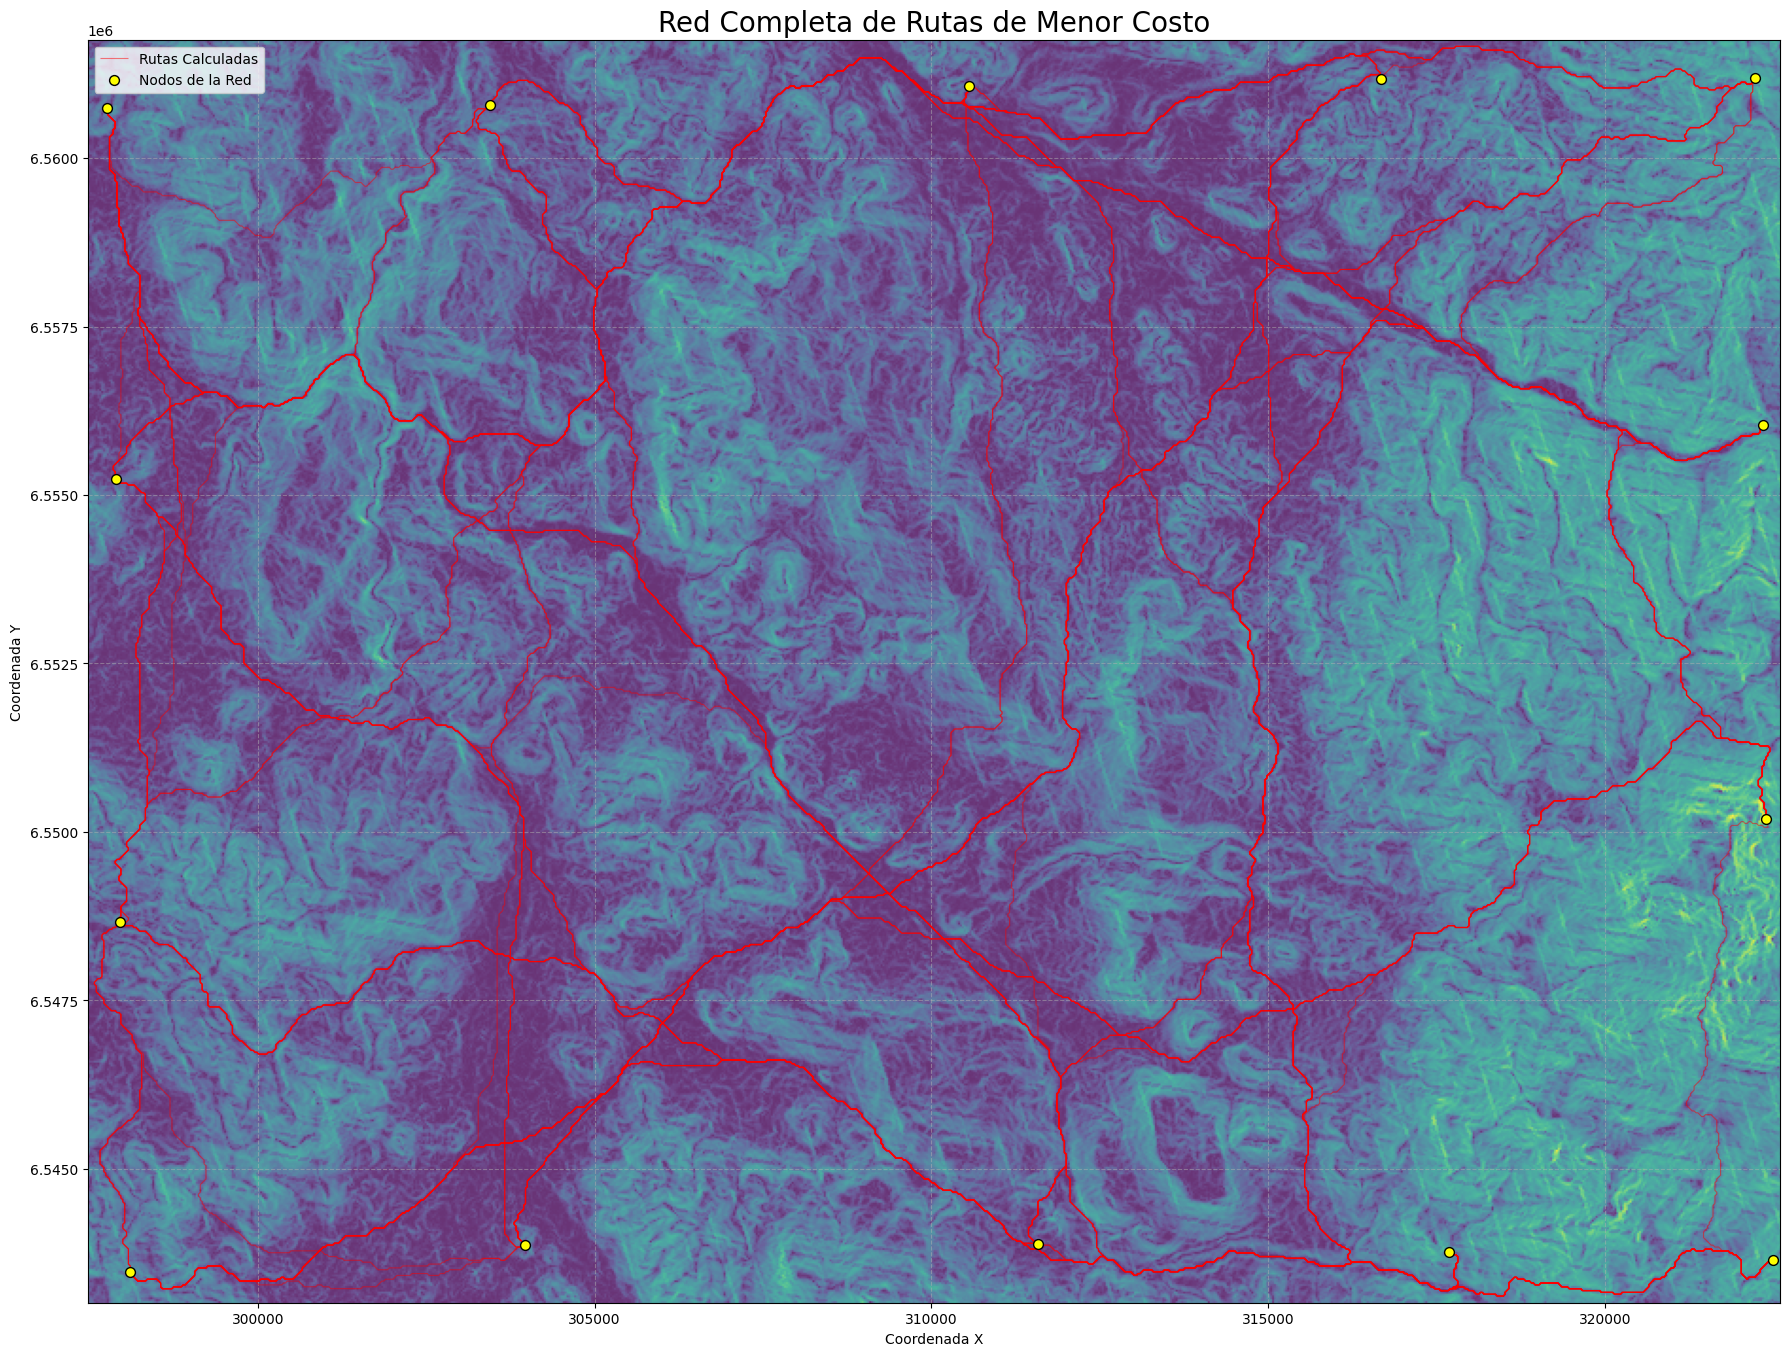

In [4]:
# ==============================================================================
# --- CELDA 4: VISUALIZACIÓN DE LA RED COMPLETA (TODOS CON TODOS) ---
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
import pandas as pd
import rasterio
import rasterio.plot
from rasterio.windows import from_bounds
import glob

print("Iniciando la visualización de la red completa de rutas...")

try:
    # --- 1. Encontrar y cargar TODAS las rutas generadas ---
    # MODIFICACIÓN: El patrón glob ahora busca cualquier ruta final, sin especificar origen.
    final_route_files = glob.glob(os.path.join(OUTPUT_DIR, 'ruta_final_*.shp'))

    if not final_route_files:
        print("No se encontraron archivos de rutas finales para visualizar.")
    else:
        # Cargar todas las rutas en un único GeoDataFrame
        final_routes_gdf = pd.concat([gpd.read_file(f) for f in final_route_files], ignore_index=True)
        
        # --- 2. Determinar la extensión total con margen ---
        minx, miny, maxx, maxy = final_routes_gdf.total_bounds
        margin = 100
        buffered_bounds = (minx - margin, miny - margin, maxx + margin, maxy + margin)
        
        # --- 3. Cargar la porción del raster ---
        with rasterio.open(COST_RASTER_PATH) as src:
            window = from_bounds(*buffered_bounds, transform=src.transform)
            raster_data = src.read(1, window=window)
            window_transform = src.window_transform(window)

        # --- 4. Cargar todos los puntos ---
        points_gdf = gpd.read_file(ALL_POINTS_SHAPEFILE)

        # --- 5. Crear el mapa ---
        fig, ax = plt.subplots(figsize=(18, 18))
        rasterio.plot.show(raster_data, transform=window_transform, ax=ax, cmap='viridis', norm=LogNorm(), alpha=0.8)
        
        # MODIFICACIÓN: Dibujar todas las rutas con alta transparencia y líneas finas
        final_routes_gdf.plot(
            ax=ax,
            edgecolor='red',
            linewidth=0.8,  # Líneas más finas
            label='Rutas Calculadas',
            alpha=0.5,      # Alta transparencia para ver superposiciones
            zorder=3
        )
        
        # MODIFICACIÓN: Dibujar todos los puntos con el mismo estilo
        points_gdf.plot(
            ax=ax,
            color='yellow',
            markersize=50,
            ec='black',
            label='Nodos de la Red',
            zorder=5
        )

        # Configuración final del mapa
        ax.set_title('Red Completa de Rutas de Menor Costo', fontsize=20)
        ax.set_xlabel("Coordenada X"); ax.set_ylabel("Coordenada Y")
        ax.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

except Exception as e:
    print(f"Ocurrió un error durante la visualización: {e}")
    import traceback
    traceback.print_exc()